# Applied Machine Learning

## Imports

In [1]:
import os

%matplotlib inline
import string
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

In [2]:
df = pd.read_csv('/Users/yangchenqi/Desktop/credit_card_customer_project/BankChurners.csv')
# Rename the column names
df.rename(columns={
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1': 'NB_Prob_Active',
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2': 'NB_Prob_Churned'
}, inplace=True)

df["Attrition_Flag"] = df["Attrition_Flag"].map({
    "Existing Customer": 0,
    "Attrited Customer": 1
})
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,NB_Prob_Active,NB_Prob_Churned
0,768805383,0,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,0,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,0,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,0,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,0,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


## Introduction
This is a binary classification problem. The task is to predict whether a credit card client will leave the service or not. The dataset is of moderate size. The number of features is rather small. I would consider this as a small dimensional problem. 

## Data Splitting

Split the data into train (80%) and test (20%) portions with `random_state = 123`.

In [3]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)
train_df.shape

(7088, 23)

## Further EDA

Select evaluation metrics: Choose one or more appropriate metrics for assessing model performance and briefly justify your choice.

In [4]:
print(
    "Fraction that default:\n",
    train_df["Attrition_Flag"].value_counts(normalize=True),
)

Fraction that default:
 Attrition_Flag
0    0.836343
1    0.163657
Name: proportion, dtype: float64


We have a class imbalance. Both classes seem important here and I am going to pick macro-average f1 score as our evaluation metric.

In [5]:
from sklearn.metrics import f1_score, make_scorer, recall_score

custom_scorer = make_scorer(f1_score, average="macro")
scoring_metric = custom_scorer

In [6]:
X_train, y_train = (
    train_df.drop(columns=["Attrition_Flag"]),
    train_df["Attrition_Flag"],
)
X_test, y_test = (
    test_df.drop(columns=["Attrition_Flag"]),
    test_df["Attrition_Flag"],
)

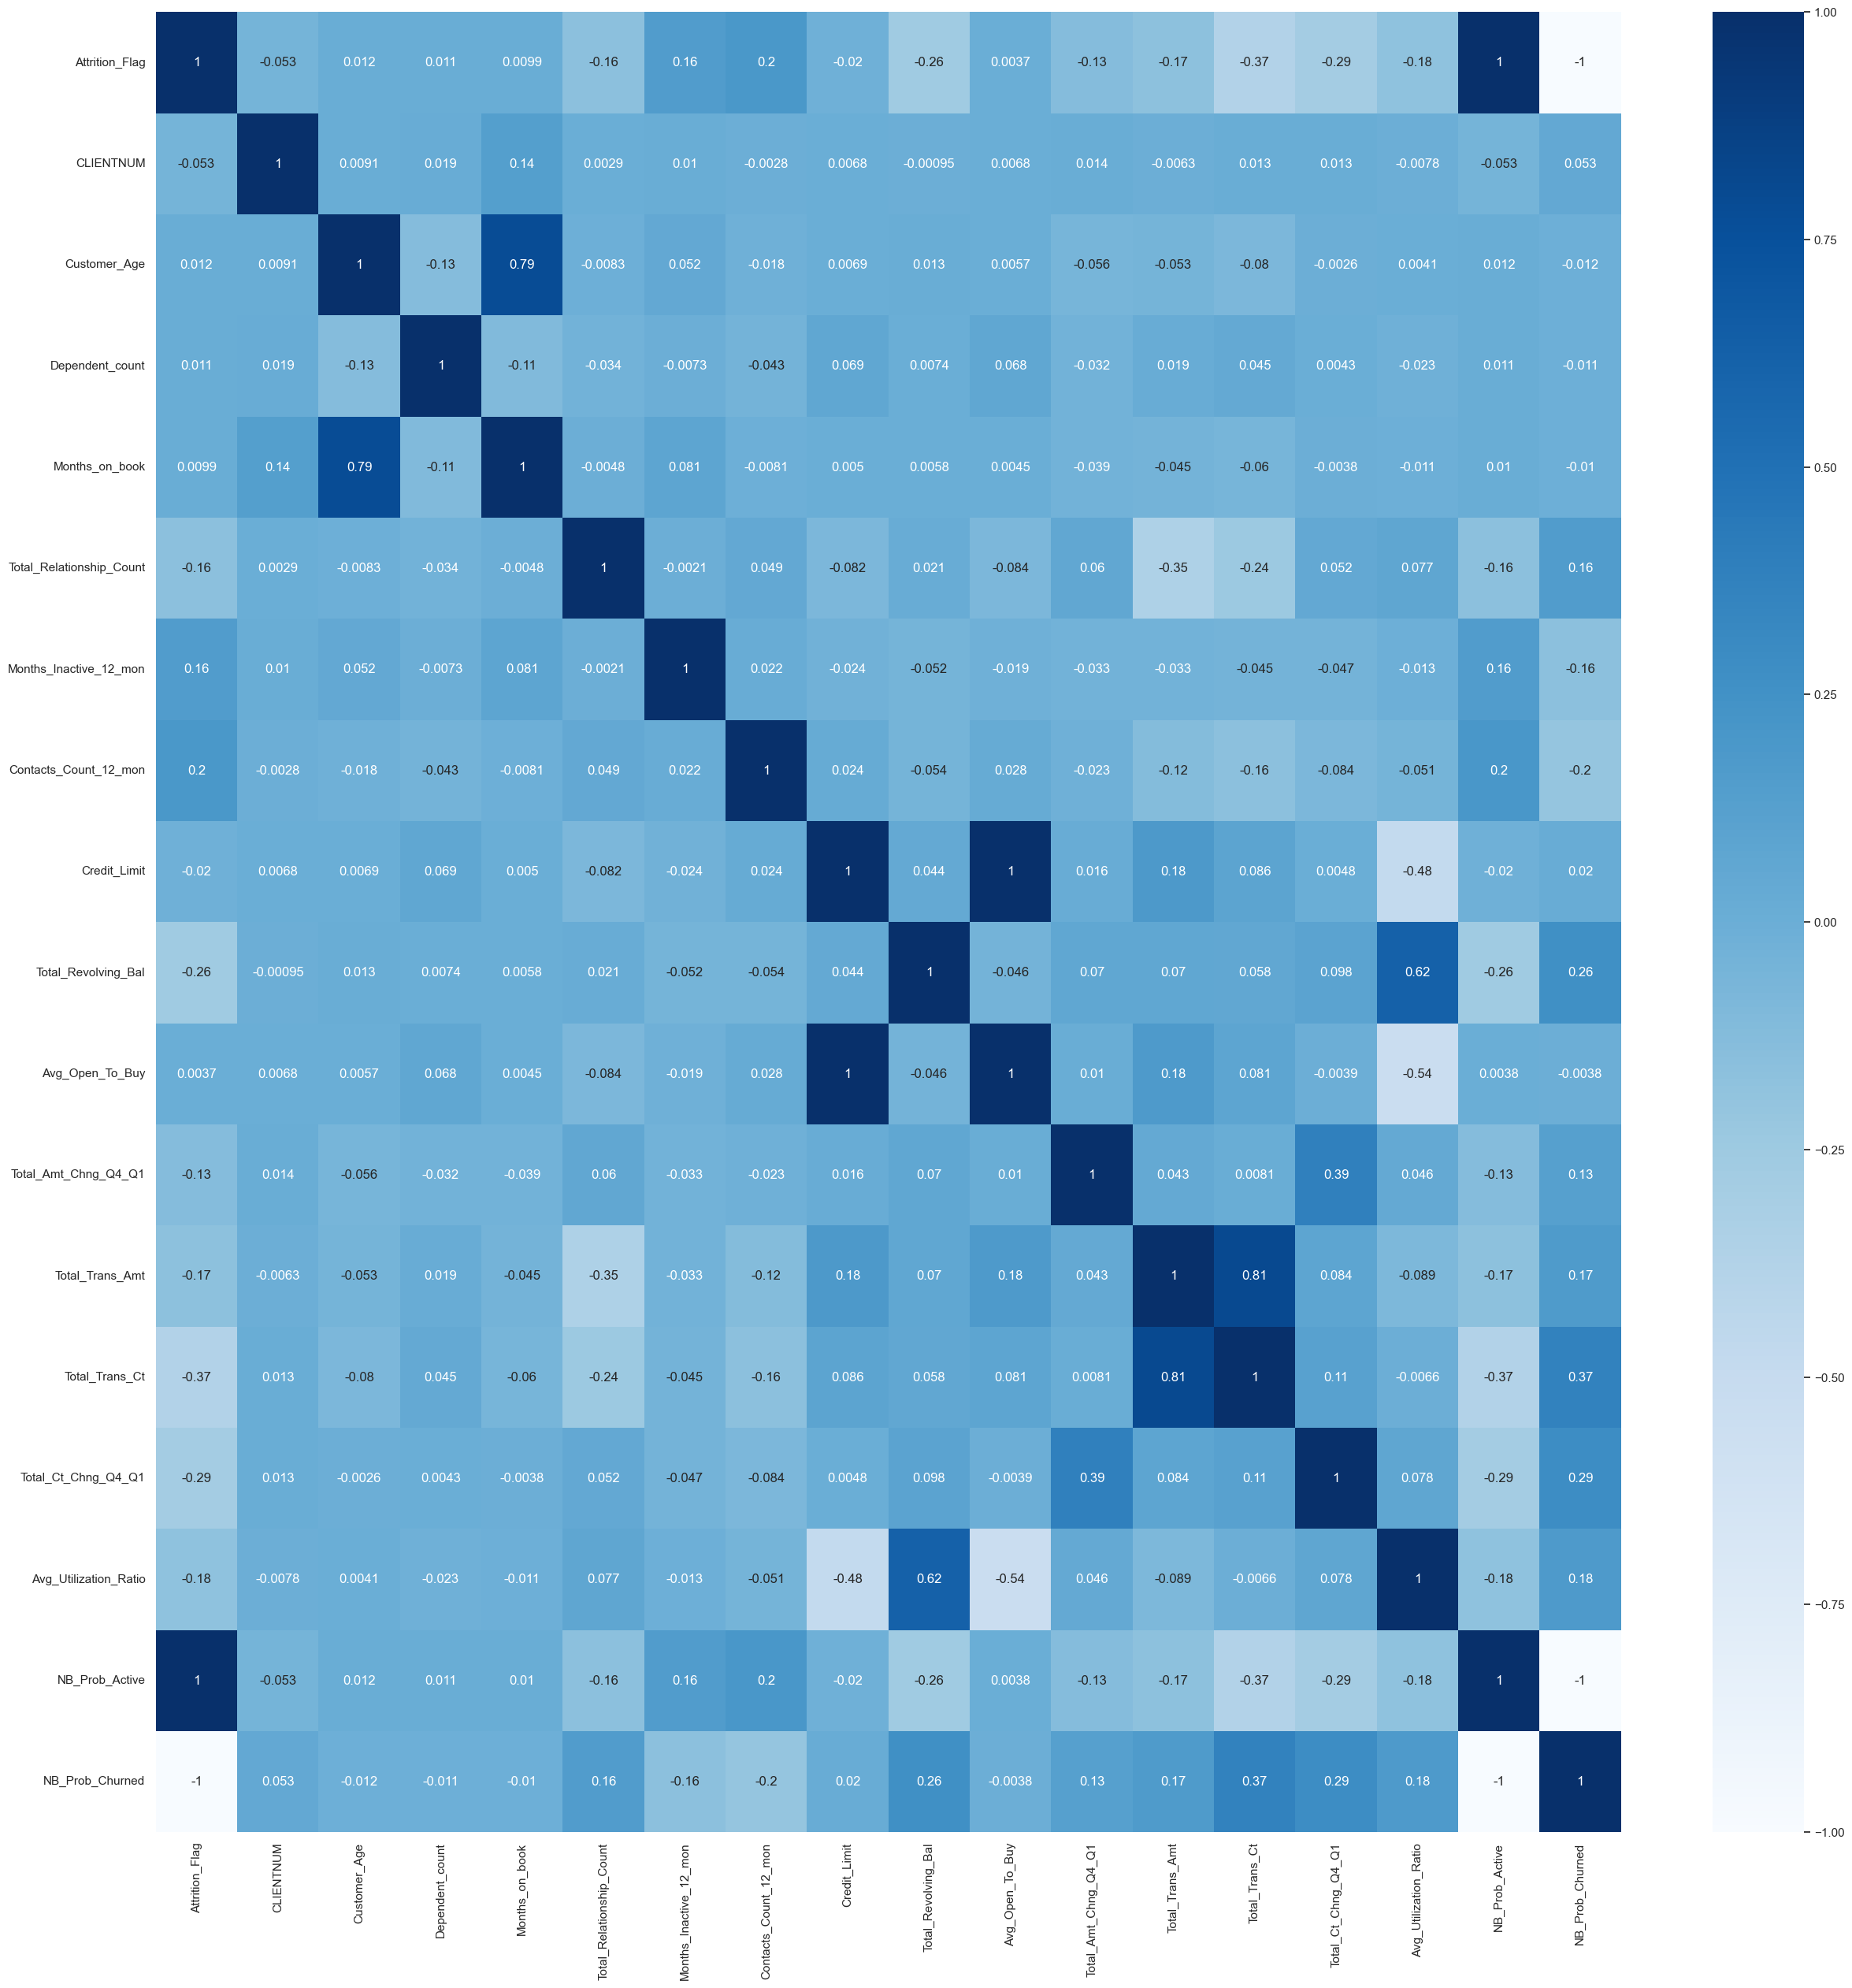

In [7]:
import seaborn as sns
cor = pd.concat((y_train, X_train), axis=1).iloc[:, :30].corr(numeric_only=True)
plt.figure(figsize=(30, 30))
sns.set(font_scale=1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

Some initial observations:

- We have class imbalance and we need to deal with it. We have chosen macro average f1 as our target metric so that both classes get equal weight.
- The feature ranges are very different, so we'll need to standardize.
- We have a number of collinear features.
    - We can also observe that there is a high correlation between features: `Customer_Age` and `Months_on_book`.
- `Attrition_Flag` is negatively correlated with `Total_Trans_Ct`. This is an early hint that total transaction count is a useful feature in predicting attritied status and there is a linear association between them.

## Preprocessing and Transformations
Identify feature types: Determine the different types of features in your dataset (e.g., numerical, categorical, ordinal, text) and specify the transformations you would apply to each type.

Define a column transformer (if needed): Implement a ColumnTransformer to apply the appropriate preprocessing steps to each feature type.

In [8]:
drop_features = ["CLIENTNUM", "NB_Prob_Active", "NB_Prob_Churned"]
numeric_features = [
    "Customer_Age",
    "Dependent_count",
    "Months_on_book",
    "Total_Relationship_Count",
    "Months_Inactive_12_mon",
    "Contacts_Count_12_mon",
    "Credit_Limit",
    "Total_Revolving_Bal",
    "Avg_Open_To_Buy",
    "Total_Amt_Chng_Q4_Q1",
    "Total_Trans_Amt",
    "Total_Trans_Ct",
    "Total_Ct_Chng_Q4_Q1",
    "Avg_Utilization_Ratio"
]
binary_features = ["Gender"]
categorical_features = ["Education_Level", 
                        "Marital_Status",
                        "Income_Category",
                        "Card_Category", 
]
target = "Attrition_Flag"

In [9]:
preprocessor = make_column_transformer(
    ("drop", drop_features),
    (StandardScaler(), numeric_features),
    (OneHotEncoder(drop="if_binary",sparse_output=False), binary_features),
    (OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
)
preprocessor.set_output(transform="pandas")


,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('drop', ...), ('standardscaler', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``featu

In [10]:
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names = (
     numeric_features
     + binary_features   
     + preprocessor.named_transformers_["onehotencoder-2"].get_feature_names_out().tolist()
 )

In [11]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

results = {}

## Baseline model
Establish a baseline: Use one of scikit-learn’s baseline models and report the results. This will serve as a reference point for evaluating the performance of your more advanced models.

In [12]:
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC

In [13]:
dummy = DummyClassifier(strategy="stratified")
results["dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,dummy
fit_time,0.010 (+/- 0.007)
score_time,0.017 (+/- 0.022)
test_score,0.497 (+/- 0.018)
train_score,0.497 (+/- 0.007)


In [14]:
cross_val_score(dummy, X_train, y_train)

array([0.74471086, 0.73554302, 0.72708039, 0.72406493, 0.71065632])

## Linear Models
Train a linear model: Use a linear model as your first real attempt at solving the problem.

Tune hyperparameters: Perform hyperparameter tuning to explore different values of the model's complexity parameter.

Evaluate with cross-validation: Report the cross-validation scores along with their standard deviation.

Summarize findings: Summarize your results, highlighting key observations from your experiments.

In [15]:
pipe_lr = make_pipeline(
    preprocessor, LogisticRegression(max_iter=1000, class_weight="balanced")
)
results["logreg"] = mean_std_cross_val_scores(
    pipe_lr, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,dummy,logreg
fit_time,0.010 (+/- 0.007),0.111 (+/- 0.058)
score_time,0.017 (+/- 0.022),0.043 (+/- 0.034)
test_score,0.497 (+/- 0.018),0.770 (+/- 0.004)
train_score,0.497 (+/- 0.007),0.774 (+/- 0.003)


In [16]:
from scipy.stats import lognorm, loguniform, randint

param_grid = {"logisticregression__C": loguniform(1e-3, 1e3)}

random_search = RandomizedSearchCV(
    pipe_lr,
    param_grid,
    n_iter=50,
    verbose=1,
    n_jobs=1,
    scoring=scoring_metric,
    random_state=123,
    return_train_score=True,
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step..._iter=1000))])
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.",{'logisticregression__C': <scipy.stats....t 0x13034bfd0>}
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",50
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",make_scorer(f...average=macro)
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None ch

In [17]:
print("Best hyperparameter values: ", random_search.best_params_)
print("Best score: %0.3f" % (random_search.best_score_))

pd.DataFrame(random_search.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_logisticregression__C",
        "mean_fit_time",
        "rank_test_score",
        "std_test_score",
    ]
].set_index("rank_test_score").sort_index()[:10]


Best hyperparameter values:  {'logisticregression__C': np.float64(0.03182234592129467)}
Best score: 0.772


,mean_train_score,mean_test_score,param_logisticregression__C,mean_fit_time,std_test_score
rank_test_score,,,,,
1,0.772754,0.772075,0.031822,0.137793,0.005029
2,0.772694,0.771331,0.022967,0.081637,0.005364
3,0.772507,0.771215,0.074742,0.085058,0.004923
4,0.772473,0.771184,0.023420,0.084848,0.005635
5,0.773453,0.770946,0.057847,0.088200,0.004824
6,0.772276,0.770940,0.080115,0.094166,0.004641
7,0.772149,0.770665,0.086647,0.127612,0.004461
8,0.772958,0.770528,0.052100,0.113977,0.004908
9,0.772209,0.770232,0.114569,0.115786,0.003861


In [18]:
best_logreg = random_search.best_estimator_
results["logreg (tuned)"] = mean_std_cross_val_scores(
    best_logreg, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.010 (+/- 0.007),0.017 (+/- 0.022),0.497 (+/- 0.018),0.497 (+/- 0.007)
logreg,0.111 (+/- 0.058),0.043 (+/- 0.034),0.770 (+/- 0.004),0.774 (+/- 0.003)
logreg (tuned),0.183 (+/- 0.109),0.090 (+/- 0.073),0.772 (+/- 0.006),0.773 (+/- 0.003)


- Logistic regression scores are better than the dummy classifier scores.
- Optimizing the regularization hyperparameter of logistic regression improved the validation scores slightly (from 0.770 to 0.772) but not by much.
- In both cases it seems like we are underfitting; there is not much gap between train and validation scores. Probably non-linear models might be a better choice here.

## Different Models
Experiment with additional models: Train three models other than a linear model. 

Compare and interpret results: Summarize your findings in terms of overfitting/underfitting behavior and fit/score times for each model. Reflect on your results. Were you able to outperform the linear model?

In [19]:
ratio = np.bincount(y_train)[0] / np.bincount(y_train)[1]
ratio

np.float64(5.110344827586207)

In [20]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier



models = {
    "RBF SVM": SVC(),
    "random forest": RandomForestClassifier(class_weight="balanced", random_state=2),
    "xgboost": XGBClassifier(scale_pos_weight=ratio, random_state=2),
}

for name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    results[name] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring_metric, 
    )

pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.010 (+/- 0.007),0.017 (+/- 0.022),0.497 (+/- 0.018),0.497 (+/- 0.007)
logreg,0.111 (+/- 0.058),0.043 (+/- 0.034),0.770 (+/- 0.004),0.774 (+/- 0.003)
logreg (tuned),0.183 (+/- 0.109),0.090 (+/- 0.073),0.772 (+/- 0.006),0.773 (+/- 0.003)
RBF SVM,1.226 (+/- 0.469),0.781 (+/- 0.221),0.866 (+/- 0.006),0.907 (+/- 0.002)
random forest,1.568 (+/- 0.118),0.077 (+/- 0.039),0.896 (+/- 0.009),1.000 (+/- 0.000)
xgboost,0.469 (+/- 0.025),0.041 (+/- 0.014),0.942 (+/- 0.005),1.000 (+/- 0.000)


I am using three non-linear models here: RBF SVM and two tree-based models.

We are trying all models with default hyperparameters.

Similar to logistic regression, SVC also seems to overfit; the gap between train and test scores are large. Also, as expected, it takes longer to score compared to other models. Let's abandon it.

XGBoost seems to be the best performing model among the tree-based models. It also seems to be much faster and overfitting less compared to random forest.

In [21]:
del models["RBF SVM"]

## Feature Selection
Perform feature selection: Attempt to select relevant features using methods such as RFECV or forward selection.

Evaluate the impact: Compare the model performance before and after feature selection. Do the results improve with feature selection?

Summarize findings: Summarize your observations and decide whether to keep feature selection in your pipeline.

In [22]:
from sklearn.feature_selection import RFE, RFECV, SelectFromModel

for name, model in models.items():
    pipe = make_pipeline(
        preprocessor,
        SelectFromModel(
            LogisticRegression(solver="liblinear", penalty="l1", max_iter=1000)
        ),
        model,
    )
    results[name + "+ feat_sel"] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring_metric
    )

/opt/anaconda3/envs/credit_card_analysis/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/opt/anaconda3/envs/credit_card_analysis/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/opt/anaconda3/envs/credit_card_analysis/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_

In [23]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.010 (+/- 0.007),0.017 (+/- 0.022),0.497 (+/- 0.018),0.497 (+/- 0.007)
logreg,0.111 (+/- 0.058),0.043 (+/- 0.034),0.770 (+/- 0.004),0.774 (+/- 0.003)
logreg (tuned),0.183 (+/- 0.109),0.090 (+/- 0.073),0.772 (+/- 0.006),0.773 (+/- 0.003)
RBF SVM,1.226 (+/- 0.469),0.781 (+/- 0.221),0.866 (+/- 0.006),0.907 (+/- 0.002)
random forest,1.568 (+/- 0.118),0.077 (+/- 0.039),0.896 (+/- 0.009),1.000 (+/- 0.000)
xgboost,0.469 (+/- 0.025),0.041 (+/- 0.014),0.942 (+/- 0.005),1.000 (+/- 0.000)
random forest+ feat_sel,2.796 (+/- 0.909),0.097 (+/- 0.040),0.900 (+/- 0.005),1.000 (+/- 0.000)
xgboost+ feat_sel,1.995 (+/- 0.878),0.081 (+/- 0.066),0.945 (+/- 0.004),1.000 (+/- 0.000)


In [24]:
pipe_random_forest = make_pipeline(
    preprocessor,
    SelectFromModel(
        LogisticRegression(solver="liblinear", penalty="l1", max_iter=1000)
    ),
    models["random forest"],
)

pipe_random_forest.fit(X_train, y_train)
print(
    "Number of features selected: ",
    pipe_random_forest.named_steps["randomforestclassifier"].n_features_in_,
)

/opt/anaconda3/envs/credit_card_analysis/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/opt/anaconda3/envs/credit_card_analysis/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


Number of features selected:  29


Total 31 features were selected by L2 regulaization. We see very small imporvements in the result with logistic regression and L2 regularization. But not a lot. Also, we do not have a large number of features. Let's abandon feature selection from the pipeline. 

## Hyperparameter Optimization
Optimize hyperparameters: Attempt to optimize hyperparameters for the models you have tried so far. In at least one case, tune multiple hyperparameters for a single model.

Use suitable optimization methods: You may use any of the following approaches for hyperparameter optimization:

GridSearchCV
RandomizedSearchCV
Bayesian optimization with scikit-optimize
Summarize your results: Report and compare the optimized results across models. Discuss whether hyperparameter optimization led to performance improvements.

In [25]:
param_grid_rf = {
    "randomforestclassifier__n_estimators": randint(low=10, high=100),
    "randomforestclassifier__max_depth": randint(low=2, high=20),
}

pipe_random_forest = make_pipeline(preprocessor, models["random forest"])

In [26]:
random_search_rf = RandomizedSearchCV(
    pipe_random_forest,
    param_grid_rf,
    n_iter=50,
    verbose=1,
    n_jobs=1,
    scoring=scoring_metric,
    random_state=123,
    return_train_score=True,
)

random_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...om_state=2))])
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'randomforestclassifier__max_depth': <scipy.stats....t 0x130330590>, 'randomforestclassifier__n_estimators': <scipy.stats....t 0x130333310>}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",50
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",make_scorer(f...average=macro)
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation str

In [27]:
print("Best hyperparameter values: ", random_search_rf.best_params_)
print("Best score: %0.3f" % (random_search_rf.best_score_))

pd.DataFrame(random_search_rf.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_randomforestclassifier__n_estimators",
        "param_randomforestclassifier__max_depth",
        "mean_fit_time",
        "rank_test_score",
        "std_test_score",
    ]
].set_index("rank_test_score").sort_index()[:10]

Best hyperparameter values:  {'randomforestclassifier__max_depth': 12, 'randomforestclassifier__n_estimators': 79}
Best score: 0.905


,mean_train_score,mean_test_score,param_randomforestclassifier__n_estimators,param_randomforestclassifier__max_depth,mean_fit_time,std_test_score
rank_test_score,,,,,,
1,0.992598,0.904753,79,12,1.671783,0.004133
2,0.975382,0.904659,35,10,0.534553,0.006702
3,0.964578,0.904552,76,9,1.953782,0.004293
4,0.986371,0.904116,62,11,1.407118,0.007387
5,0.991845,0.903456,67,12,2.950603,0.003488
6,0.986055,0.903160,42,11,1.266126,0.009404
7,0.998073,0.902723,58,14,2.167151,0.006469
8,0.991012,0.902487,32,12,0.805789,0.008177
9,0.950922,0.901905,95,8,1.718590,0.007356


In [28]:
best_rf_model = random_search_rf.best_estimator_
results["random forest (tuned)"] = mean_std_cross_val_scores(
    best_rf_model, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.010 (+/- 0.007),0.017 (+/- 0.022),0.497 (+/- 0.018),0.497 (+/- 0.007)
logreg,0.111 (+/- 0.058),0.043 (+/- 0.034),0.770 (+/- 0.004),0.774 (+/- 0.003)
logreg (tuned),0.183 (+/- 0.109),0.090 (+/- 0.073),0.772 (+/- 0.006),0.773 (+/- 0.003)
RBF SVM,1.226 (+/- 0.469),0.781 (+/- 0.221),0.866 (+/- 0.006),0.907 (+/- 0.002)
random forest,1.568 (+/- 0.118),0.077 (+/- 0.039),0.896 (+/- 0.009),1.000 (+/- 0.000)
xgboost,0.469 (+/- 0.025),0.041 (+/- 0.014),0.942 (+/- 0.005),1.000 (+/- 0.000)
random forest+ feat_sel,2.796 (+/- 0.909),0.097 (+/- 0.040),0.900 (+/- 0.005),1.000 (+/- 0.000)
xgboost+ feat_sel,1.995 (+/- 0.878),0.081 (+/- 0.066),0.945 (+/- 0.004),1.000 (+/- 0.000)
random forest (tuned),1.713 (+/- 0.523),0.116 (+/- 0.081),0.905 (+/- 0.005),0.993 (+/- 0.002)


#### XGBoost Hyperparameter optimization

In [29]:
param_grid_xgb = {
    "xgbclassifier__n_estimators": randint(10, 100),
    "xgbclassifier__max_depth": randint(low=2, high=20),
    "xgbclassifier__learning_rate": [0.01, 0.1],
    "xgbclassifier__subsample": [0.5, 0.75, 1],
}


pipe_xgb = make_pipeline(
    preprocessor,
    models["xgboost"],
)

In [30]:
random_search_xgb = RandomizedSearchCV(
    pipe_xgb,           
    param_grid_xgb,     
    n_iter=50,
    verbose=1,
    n_jobs=1,
    scoring=scoring_metric,
    random_state=123,
    return_train_score=True,
)


random_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","Pipeline(step...=None, ...))])"
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'xgbclassifier__learning_rate': [0.01, 0.1], 'xgbclassifier__max_depth': <scipy.stats....t 0x130301d90>, 'xgbclassifier__n_estimators': <scipy.stats....t 0x13006b990>, 'xgbclassifier__subsample': [0.5, 0.75, ...]}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",50
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",make_scorer(f...average=macro)
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the sam

In [31]:
print("Best hyperparameter values: ", random_search_xgb.best_params_)
print("Best score: %0.3f" % (random_search_xgb.best_score_))

pd.DataFrame(random_search_xgb.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_xgbclassifier__n_estimators",    
        "param_xgbclassifier__learning_rate",  
        "param_xgbclassifier__subsample",       
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index()[:10]

Best hyperparameter values:  {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 6, 'xgbclassifier__n_estimators': 90, 'xgbclassifier__subsample': 0.5}
Best score: 0.942


,mean_train_score,mean_test_score,param_xgbclassifier__n_estimators,param_xgbclassifier__learning_rate,param_xgbclassifier__subsample,mean_fit_time
rank_test_score,,,,,,
1,0.986583,0.941628,90,0.1,0.50,0.567849
2,0.999743,0.941118,96,0.1,0.75,0.972804
3,0.995390,0.939317,73,0.1,0.50,1.083150
4,0.991966,0.938835,58,0.1,0.50,0.600180
5,0.997944,0.938621,64,0.1,0.75,0.730347
6,0.994754,0.938086,66,0.1,0.50,0.587768
7,0.995582,0.937869,79,0.1,0.50,0.874005
8,0.999614,0.936612,98,0.1,1.00,0.986337
9,0.998842,0.936344,95,0.1,1.00,1.664172


In [32]:
best_xgb_model = random_search_xgb.best_estimator_

results["xgboost (tuned)"] = mean_std_cross_val_scores(
    best_xgb_model, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.010 (+/- 0.007),0.017 (+/- 0.022),0.497 (+/- 0.018),0.497 (+/- 0.007)
logreg,0.111 (+/- 0.058),0.043 (+/- 0.034),0.770 (+/- 0.004),0.774 (+/- 0.003)
logreg (tuned),0.183 (+/- 0.109),0.090 (+/- 0.073),0.772 (+/- 0.006),0.773 (+/- 0.003)
RBF SVM,1.226 (+/- 0.469),0.781 (+/- 0.221),0.866 (+/- 0.006),0.907 (+/- 0.002)
random forest,1.568 (+/- 0.118),0.077 (+/- 0.039),0.896 (+/- 0.009),1.000 (+/- 0.000)
xgboost,0.469 (+/- 0.025),0.041 (+/- 0.014),0.942 (+/- 0.005),1.000 (+/- 0.000)
random forest+ feat_sel,2.796 (+/- 0.909),0.097 (+/- 0.040),0.900 (+/- 0.005),1.000 (+/- 0.000)
xgboost+ feat_sel,1.995 (+/- 0.878),0.081 (+/- 0.066),0.945 (+/- 0.004),1.000 (+/- 0.000)
random forest (tuned),1.713 (+/- 0.523),0.116 (+/- 0.081),0.905 (+/- 0.005),0.993 (+/- 0.002)
xgboost (tuned),0.719 (+/- 0.560),0.028 (+/- 0.002),0.942 (+/- 0.005),0.987 (+/- 0.003)


Summary of observations

Hyperparameter optimization seems to help with random forests as well as XGBoost. But we pick LightGBM because

- it seems to be less overfitting
- it's much faster


## Interpretation and feature importances
Interpret model feature importance: Use one of the interpretation methods discussed in class (e.g., shap), or another suitable method of your choice, to examine the most important features of one of your non-linear models.

Summarize insights: Summarize your observations about which features contribute most to the model's predictions and how they influence the outcomes.

In [33]:
import shap

preprocessor.fit(X_train, y_train)

X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train),
    columns=preprocessor.get_feature_names_out(),
    index=X_train.index,
)

X_train_enc.head()

,standardscaler__Customer_Age,standardscaler__Dependent_count,standardscaler__Months_on_book,standardscaler__Total_Relationship_Count,standardscaler__Months_Inactive_12_mon,standardscaler__Contacts_Count_12_mon,standardscaler__Credit_Limit,standardscaler__Total_Revolving_Bal,standardscaler__Avg_Open_To_Buy,standardscaler__Total_Amt_Chng_Q4_Q1,...,onehotencoder-2__Income_Category_$120K +,onehotencoder-2__Income_Category_$40K - $60K,onehotencoder-2__Income_Category_$60K - $80K,onehotencoder-2__Income_Category_$80K - $120K,onehotencoder-2__Income_Category_Less than $40K,onehotencoder-2__Income_Category_Unknown,onehotencoder-2__Card_Category_Blue,onehotencoder-2__Card_Category_Gold,onehotencoder-2__Card_Category_Platinum,onehotencoder-2__Card_Category_Silver
4503,0.326774,1.275550,0.502311,0.774032,-1.326404,-1.317528,-0.053443,0.673539,-0.113737,0.275464,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
365,-0.421142,1.275550,0.376980,-0.508272,0.656000,0.489834,0.687221,-0.380323,0.721195,0.013868,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1887,-0.171837,-0.270333,0.251650,0.132880,3.629605,1.393515,0.877927,-1.424336,1.005347,0.895035,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5458,0.326774,1.275550,0.126320,-1.790577,-0.335202,-0.413847,0.170664,1.516875,0.034842,-1.523585,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
85,0.700732,-0.270333,1.379621,0.774032,0.656000,-2.221209,-0.613102,0.927155,-0.696040,0.743584,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [34]:
xgb_tuned = XGBClassifier(
    scale_pos_weight=ratio,
    random_state=2,
    learning_rate=random_search_xgb.best_params_["xgbclassifier__learning_rate"],
    n_estimators=random_search_xgb.best_params_["xgbclassifier__n_estimators"],
    subsample=random_search_xgb.best_params_["xgbclassifier__subsample"],
    max_depth=random_search_xgb.best_params_["xgbclassifier__max_depth"] 
)

xgb_tuned.fit(X_train_enc, y_train)
xgb_explainer = shap.TreeExplainer(xgb_tuned)
xgb_shap_values = xgb_explainer.shap_values(X_train_enc)

In [35]:
X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=preprocessor.get_feature_names_out(),    
    index=X_test.index,
)
test_shap_values = xgb_explainer(X_test_enc)

In [36]:
values = np.abs(xgb_shap_values[0]).mean(0)
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)[:10]

,SHAP
Customer_Age,0.256333
Dependent_count,0.256333
Months_on_book,0.256333
Total_Relationship_Count,0.256333
Months_Inactive_12_mon,0.256333
Contacts_Count_12_mon,0.256333
Credit_Limit,0.256333
Total_Revolving_Bal,0.256333
Avg_Open_To_Buy,0.256333
Total_Amt_Chng_Q4_Q1,0.256333


In [37]:
shap.initjs()

In [38]:
ex1_idx = 100
ex2_idx = 499

In [39]:
X_test_enc.iloc[ex1_idx]

standardscaler__Customer_Age                      -0.670448
standardscaler__Dependent_count                    0.502608
standardscaler__Months_on_book                    -0.750990
standardscaler__Total_Relationship_Count           0.132880
standardscaler__Months_Inactive_12_mon            -0.335202
standardscaler__Contacts_Count_12_mon             -0.413847
standardscaler__Credit_Limit                       1.018916
standardscaler__Total_Revolving_Bal                1.674461
standardscaler__Avg_Open_To_Buy                    0.868892
standardscaler__Total_Amt_Chng_Q4_Q1               1.028128
standardscaler__Total_Trans_Amt                    0.120794
standardscaler__Total_Trans_Ct                     0.684701
standardscaler__Total_Ct_Chng_Q4_Q1                0.371401
standardscaler__Avg_Utilization_Ratio             -0.479748
onehotencoder-1__Gender_M                          1.000000
onehotencoder-2__Education_Level_College           0.000000
onehotencoder-2__Education_Level_Doctora

In [40]:
y_test.iloc[ex1_idx]

np.int64(0)

In [41]:
xgb_tuned.predict(X_test_enc)[ex1_idx]

np.int64(0)

In [42]:
xgb_tuned.predict_proba(X_test_enc)[ex1_idx]

array([0.9910278 , 0.00897224], dtype=float32)

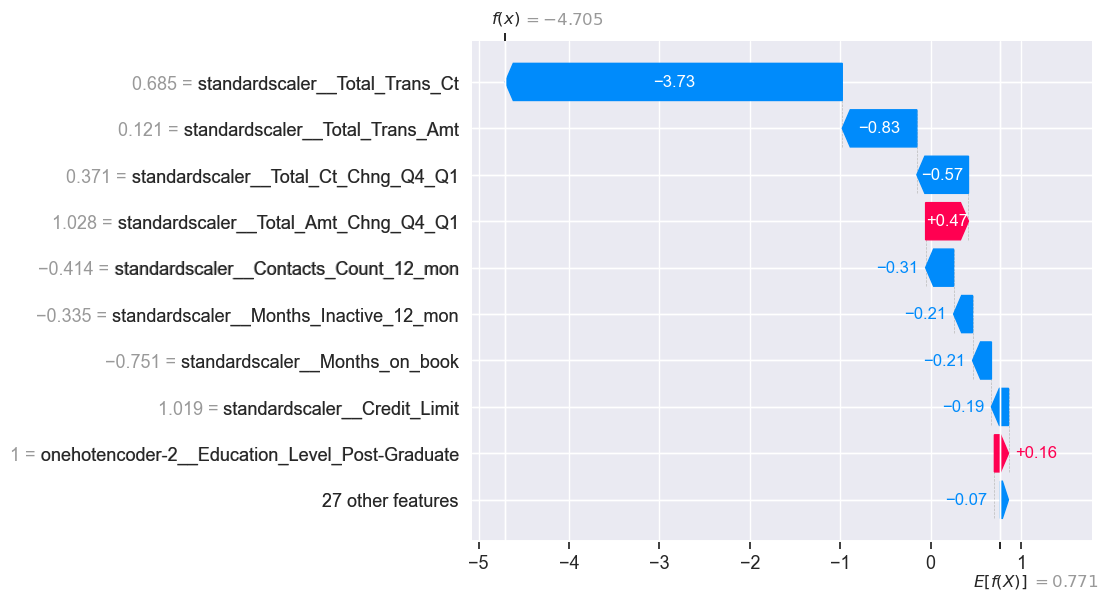

In [43]:
shap.plots.waterfall(test_shap_values[ex1_idx])

#### Explain XGBoost's predictions for one example from the test set (Example 1: existing customer)

Looking at this SHAP plot, we can see that 

1. a low value of total transaction count 
2. and fact that this client's total transaction amount are reducing the probability of this client to be classified as attrited customer. 

On the other hand,

1. the fact that this client has a lower than average Change in Transaction Amount (Q4 over Q1) has a positive impact.

Ultimately, this client has a predicted raw score of -4.705, a lot lower than the value of 0.771 expected for the “average” client in this dataset and would therefore being assigned to the negative class (existing customer)



In [44]:
X_test_enc.iloc[ex2_idx]

standardscaler__Customer_Age                      -0.171837
standardscaler__Dependent_count                    0.502608
standardscaler__Months_on_book                     0.000990
standardscaler__Total_Relationship_Count           0.132880
standardscaler__Months_Inactive_12_mon            -0.335202
standardscaler__Contacts_Count_12_mon              1.393515
standardscaler__Credit_Limit                      -0.696329
standardscaler__Total_Revolving_Bal                1.399916
standardscaler__Avg_Open_To_Buy                   -0.821583
standardscaler__Total_Amt_Chng_Q4_Q1              -1.390492
standardscaler__Total_Trans_Amt                   -0.680196
standardscaler__Total_Trans_Ct                    -1.063540
standardscaler__Total_Ct_Chng_Q4_Q1               -1.598015
standardscaler__Avg_Utilization_Ratio              2.590942
onehotencoder-1__Gender_M                          0.000000
onehotencoder-2__Education_Level_College           1.000000
onehotencoder-2__Education_Level_Doctora

In [45]:
y_test.iloc[ex2_idx]

np.int64(1)

In [46]:
xgb_tuned.predict(X_test_enc)[ex2_idx]

np.int64(1)

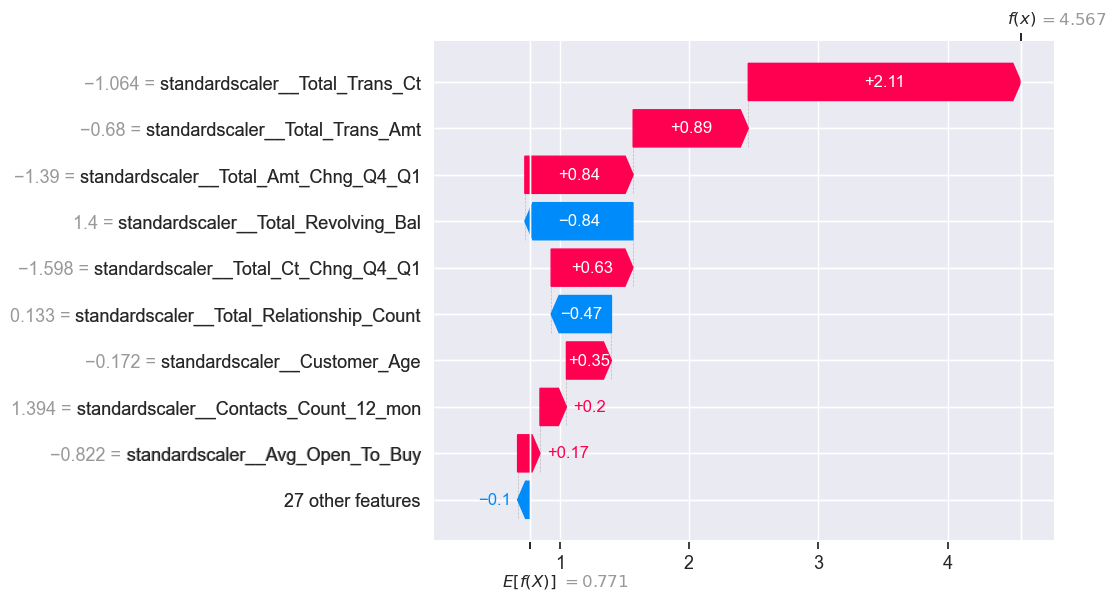

In [47]:
shap.plots.waterfall(test_shap_values[ex2_idx])

#### Explain XGBoost's predictions for one example from the test set (Example 2: attrited customer)

From the SHAP plot, we can see that high value of total transaction count and have a positive impact on this person’s account status. Same as total transaction amount, Change in Transaction Amount (Q4 over Q1) and Change in Transaction Count that increases the probability of this person’s income to be classified as attrited customer that pushes the prediction upward, toward the + 1 class. 

On the other hand, a low value of total revolving balance has a negative impact on this person’s account status and decrease the probability of this person’s account status to be classified as attrited customer. 

Ultimately, the raw predicted score is 4.567, quite higher than the value of 0.771 expected for account status in this dataset and would therefore being assigned to the positive class (attrited customer)

## Results on the test set
Evaluate on the test set: Apply your best-performing model to the test data and report the test scores.

Compare and reflect: Compare the test scores with the validation scores from previous experiments. Discuss the consistency between them. How much do you trust your results? Reflect on whether you might have encountered optimization bias.


In [48]:
from sklearn.metrics import f1_score

best_model = random_search_xgb.best_estimator_
print(
    "Grid Search best model validation score: %0.3f" % (random_search_xgb.best_score_)
)

predictions = best_model.predict(X_test)
print(
    "Macro-average f1 score on the test set: %0.3f"
    % (f1_score(y_test, predictions, average="macro"))
)

Grid Search best model validation score: 0.942
Macro-average f1 score on the test set: 0.936


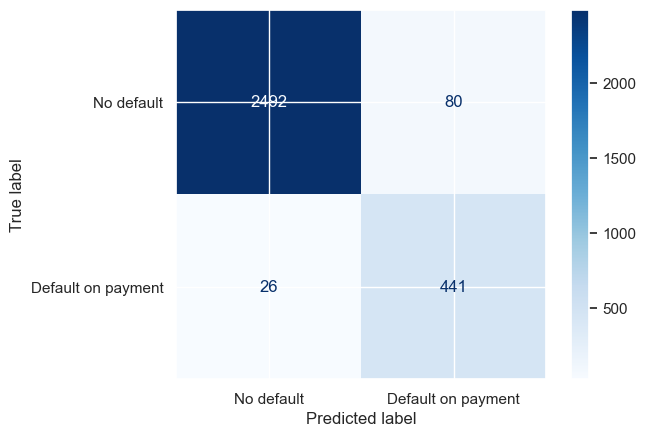

In [49]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    best_model,
    X_test,
    y_test,
    display_labels=["No default", "Default on payment"],
    values_format="d",
    cmap=plt.cm.Blues,
)

In [50]:
print(
    classification_report(
        y_test, predictions, target_names=["No default", "Default on payment"]
    )
)

                    precision    recall  f1-score   support

        No default       0.99      0.97      0.98      2572
Default on payment       0.85      0.94      0.89       467

          accuracy                           0.97      3039
         macro avg       0.92      0.96      0.94      3039
      weighted avg       0.97      0.97      0.97      3039



The macro-average f1-score (0.942) on the held-out test set is pretty much in line with the macro-average f1-score validation score (0.936). So there doesn't seem to be severe optimization bias here.

## Summary of results
Summarize key results: Create a clear and concise table highlighting your most important results (e.g., models compared, validation/test scores, key observations).

Write concluding remarks: Summarize your main takeaways from the project, including what worked well and what did not.

Propose future improvements: Discuss ideas or approaches you did not try but that could potentially improve performance or interpretability.

Report final results: Report your final test score and the metric you used.

In [51]:
pd.DataFrame(results).T
summary_df = pd.DataFrame(results).T

In [52]:
comments = {
    "dummy": "Baseline of 0.50 macro-average f1 score.",
    "logreg": "Improvement over the baseline but underfitting.",
    "logreg (tuned)": "Slight improvement but still underfitting.",
    "RBF SVM": "Improvement over tuned logistic regression but slow.",
    "random forest": "Improvement over tuned logistic regression but overfitting.",
    "xgboost": "Best results so far and less overfitting compared to random forest.",
    "random forest+ feat_sel": "Feature selection with L1 regularization helps a tiny bit. Selects 29 features.",
    "xgboost+ feat_sel": "Very tiny improvement with L1 feature selection.",
    "random forest (tuned)": "Hyperparameter optimization helped!",
    "xgboost (tuned)": "Hyperparameter optimization helped! Best results so far.",

}
pd.set_option("display.max_colwidth", 0)
summary_df["comments"] = summary_df.index.map(comments)
summary_df

,fit_time,score_time,test_score,train_score,comments
dummy,0.010 (+/- 0.007),0.017 (+/- 0.022),0.497 (+/- 0.018),0.497 (+/- 0.007),Baseline of 0.50 macro-average f1 score.
logreg,0.111 (+/- 0.058),0.043 (+/- 0.034),0.770 (+/- 0.004),0.774 (+/- 0.003),Improvement over the baseline but underfitting.
logreg (tuned),0.183 (+/- 0.109),0.090 (+/- 0.073),0.772 (+/- 0.006),0.773 (+/- 0.003),Slight improvement but still underfitting.
RBF SVM,1.226 (+/- 0.469),0.781 (+/- 0.221),0.866 (+/- 0.006),0.907 (+/- 0.002),Improvement over tuned logistic regression but slow.
random forest,1.568 (+/- 0.118),0.077 (+/- 0.039),0.896 (+/- 0.009),1.000 (+/- 0.000),Improvement over tuned logistic regression but overfitting.
xgboost,0.469 (+/- 0.025),0.041 (+/- 0.014),0.942 (+/- 0.005),1.000 (+/- 0.000),Best results so far and less overfitting compared to random forest.
random forest+ feat_sel,2.796 (+/- 0.909),0.097 (+/- 0.040),0.900 (+/- 0.005),1.000 (+/- 0.000),Feature selection with L1 regularization helps a tiny bit. Selects 29 features.
xgboost+ feat_sel,1.995 (+/- 0.878),0.081 (+/- 0.066),0.945 (+/- 0.004),1.000 (+/- 0.000),Very tiny improvement with L1 feature selection.
random forest (tuned),1.713 (+/- 0.523),0.116 (+/- 0.081),0.905 (+/- 0.005),0.993 (+/- 0.002),Hyperparameter optimization helped!
xgboost (tuned),0.719 (+/- 0.560),0.028 (+/- 0.002),0.942 (+/- 0.005),0.987 (+/- 0.003),Hyperparameter optimization helped! Best results so far.


### Concluding remarks
All our models beat the baseline. Our best model was XGBoost classifier with tuned hyperparameters. It achieved cross-validation macro-average f1 score of 0.942. The scores do not seem to overfit much; the gap between mean train score (0.987) and mean cross-validation score (0.942) is not big. So picked XGBoost model as out final model. 